
<div align="center">
  <a href="https://www.w-hs.de/maschinenbau-master-boh/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png" 
    alt="Images" width="500" height="200">
  </a>
</div>
<br>
<h1 align="center"> Sondergebiete der Simulation</h1>
<h3 align="center"> WS 21/22 </h3>
<br>

<br>

### Credits:

* [benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

In [2]:
import sympy
from sympy import symbols, Function, diff, sin, cos, Matrix, Rational, Eq, solve, lambdify
import sympy.physics.mechanics as mech
mech.init_vprinting()

### Herleitung der Bewegungsgleichungen 

Ausführliche Beschreibung der Herleitung:
[Inverted Pendulum Legrange](https://github.com/lennart2810/InvertedPendulumSDS/blob/master/MKS/Inverted%20Pendulum%20Legrange.ipynb) 

In [3]:
# symbolischen Variablen anlegen
t, l, M, m, g = symbols('t l M m g')

# Zwangsbedingung
y = 0

# generalisierte Koordinaten und deren Ableitungen:
x = Function('x')(t)
x_d = diff(x,t)
x_dd = diff(x_d,t)

theta = Function('theta')(t)
theta_d = diff(theta,t)
theta_dd = diff(theta,t,t)

# Kinematik
x2, y2 = x - l * sin(theta), y + l * cos(theta)
x2_d, y2_d = x2.diff(t), y2.diff(t)

# Legrange-Funktion
T = Rational(1,2) * M * (x_d)**2 + Rational(1,2) * m * (x2_d**2 + y2_d**2)
V = M * g * y + m * g * y2 
L = T - V

# Euler-Legrange
LE_x = diff(diff(L, x_d), t) - diff(L, x)
LE_theta = diff(diff(L, theta_d), t) - diff(L, theta)
display(Matrix([LE_x.simplify(), LE_theta.simplify()]))

# Nach x_dd und theta_dd umstellen
solutions = solve([LE_x, LE_theta], (x_dd, theta_dd), simplify=True) 
sol_x_dd = Eq(x_dd-solutions[x_dd], 0)
sol_theta_dd = Eq(theta_dd - solutions[theta_dd], 0)
#display(Matrix([sol_x_dd, sol_theta_dd]))

⎡        ⎛          2                 ⎞⎤
⎢M⋅ẍ + m⋅⎝l⋅sin(θ)⋅θ̇  - l⋅cos(θ)⋅θ̈ + ẍ⎠⎥
⎢                                      ⎥
⎣   l⋅m⋅(-g⋅sin(θ) + l⋅θ̈ - cos(θ)⋅ẍ)   ⎦

In [4]:
# M*x_dd+m*(l*sin(theta)*theta_d**2-l*cos(theta)*theta_dd+x_dd)
# l*m*(-g*sin(theta)+l*theta_dd-cos(theta)*x_dd)

### Umwandlung des symbolischen Gleichungssystems in numerische Funktionen mit `sympy.lambdify`.

In [5]:
dxdt = lambdify(x_d, x_d)
dvdt = lambdify((t,g,M,m,l,theta,theta_d), solutions[x_dd])

dthetadt = lambdify(theta_d, theta_d)
domegadt = lambdify((t,g,M,m,l,theta,theta_d), solutions[theta_dd])

def dSdt(S, t, g, M, m, l):
    x, v, theta, omega = S
    return [
        dxdt(v),
        dvdt(t,g,M,m,l,theta, omega),
        dthetadt(omega),
        domegadt(t,g,M,m,l,theta,omega)
    ]

### Daten generieren

time.shape: (85,) <class 'numpy.ndarray'>
x.shape: (85,)
theta.shape: (85,)
data.shape: (85, 2)


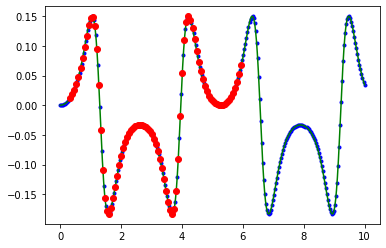

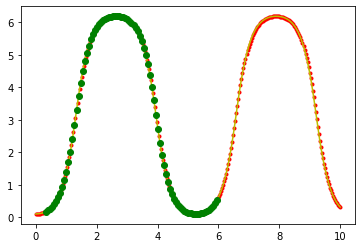

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interpolate

t1 = 10                          # s 
samples = 300                    # n 
t = np.linspace(0, t1, samples)  # s

g = 9.81                         # m/s^2
M = 5                            # kg
m = 1                            # kg
l = 1                            # m
F = 0                            # N

S0 = [0, 0, 0.1, 0]              # m, m/s, rad, rad/s

# numerische Lösung
ans = odeint(dSdt, y0=S0, t=t, args=(g, M, m, l))
x = ans.T[0]
theta = ans.T[2]

# numerische Lösung --> Lösungsfunktion interpolieren (für DeepXDE)
t_new = np.linspace(0, t1, samples+2000)    
x_f = interpolate.interp1d(t, x, 'cubic')
theta_f = interpolate.interp1d(t, theta, 'cubic')

# 'Messwerte'
a, b, i = 10, 180, 2 # jeden i. Punkt im Intervall [a,b] 
t_data = t[a:b:i]
x_data = x[a:b:i]
theta_data = theta[a:b:i]

# Data für NN zusammenfassen: (nur nötig wenn 1 Model mit 2 Outputs genutzt wird)
data = np.concatenate((x_data, theta_data)).reshape(2, len(t_data)).T
print('time.shape:', t_data.shape, type(t_data))
print('x.shape:', x_data.shape)
print('theta.shape:', theta_data.shape)
print('data.shape:', data.shape)


# Visualisierung 
plt.plot(t, x, 'b.')
plt.plot(t_new, x_f(t_new), 'g-')
plt.plot(t_data, data[:,0], 'ro') # data[:,1] --> x_data
plt.show()

plt.plot(t, theta, 'r.')
plt.plot(t_new, theta_f(t_new), 'y-')
plt.plot(t_data, data[:,1], 'go') # data[:,1] --> theta_data
plt.show()

## DeepXDE 

Compiling model...
Building feed-forward neural network...
'build' took 0.036225 s



C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.506856 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [4.00e-07, 6.75e+00, 2.77e-01, 2.98e-02]    [4.03e-07, 6.75e+00, 2.77e-01, 2.98e-02]    [9.57e-01]    
1000      [2.02e-06, 5.97e-04, 3.96e-13, 8.57e-03]    [2.09e-06, 5.36e-04, 3.96e-13, 8.57e-03]    [1.00e+00]    
2000      [1.82e-05, 8.39e-04, 4.88e-13, 8.05e-03]    [1.80e-05, 7.28e-04, 4.88e-13, 8.05e-03]    [1.00e+00]    
3000      [2.48e-05, 1.21e-03, 7.70e-14, 6.03e-03]    [2.33e-05, 7.79e-04, 7.70e-14, 6.03e-03]    [1.00e+00]    
4000      [2.40e-05, 1.59e-03, 2.12e-08, 3.26e-03]    [1.91e-05, 5.30e-04, 2.12e-08, 3.26e-03]    [1.00e+00]    
5000      [5.09e-06, 4.55e-04, 1.03e-12, 4.56e-04]    [2.29e-06, 4.55e-04, 1.03e-12, 4.56e-04]    [1.00e+00]    
6000      [4.01e-06, 3.97e-04, 3.47e-14, 6.21e-05]    [8.52e-06, 7.83e-04, 3.47e-14, 6.21e-05]    [1.00e+00]    
7000      [3.11e-06, 2.8

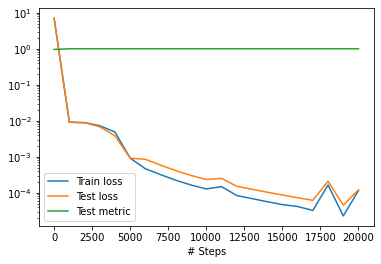

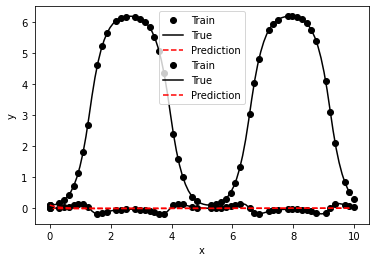

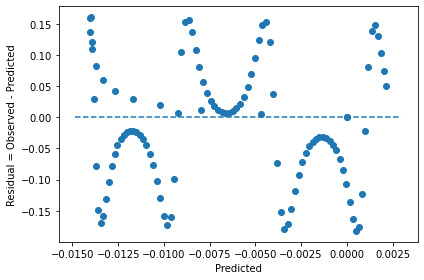

In [11]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
from deepxde.backend import sin
import tensorflow as tf


def ode_system_ip(t, y):
    
    x, theta = y[:, 0:1], y[:, 1:]
    
    x_d = dde.grad.jacobian(y, t, i=0)
    theta_d = dde.grad.jacobian(y, t, i=0)
    
    x_dd = dde.grad.hessian(y, t, component=0, i=0, j=0)
    theta_dd = dde.grad.hessian(y, t, component=1, i=0, j=0)
    
    sin_theta = tf.sin(theta)
    cos_theta = tf.cos(theta)
    
    # M*x_dd+m*(l*sin(theta)*theta_d**2-l*cos(theta)*theta_dd+x_dd)
    
    eq_x = M*x_dd+m*(l*tf.sin(theta)*theta_d**2-l*tf.cos(theta)*theta_dd+x_dd)
    eq_theta = l*m*(-g*tf.sin(theta)+l*theta_dd-tf.cos(theta)*x_dd)

    return [eq_x, eq_theta]


def boundary(_, on_initial):
    return on_initial

def func(t):

    return np.hstack((x_f(t), theta_f(t)))


geom = dde.geometry.TimeDomain(0, t1)
ic1 = dde.IC(geom, x_f, boundary, component=0)
ic2 = dde.IC(geom, theta_f, boundary, component=1)
data = dde.data.PDE(geom, ode_system_ip, [ic1, ic2], num_domain=50, num_boundary=2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "sigmoid"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)